# Non-parametric Bayes: Gaussian Processes

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the first and fundamental step in Bayesian modeling is to specify a *full probability model* for the problem at hand. It is rather difficult to explicitly state a full probability model without the use of probability functions, which are parametric. Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

## Building models with Gaussians

It is easy to develop large, parametric models $p(y|\theta)$ for large $\theta$, particularly in a Bayesian context. However, this usually results in having to work with multidimensional integration over $\theta$. 

One approach is to use MCMC; another is to represent your model with Gaussians. Normal distributions are easier to work with.

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

* marginals of multivariate normal distributions are normal

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

* conditionals of multivariate normals are normal

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$


In some situations, we want to gain inference about *functions*, rather than about, say, individuals or small vectors of parameters.

A Gaussian process generalizes the multivariate normal to infinite dimension. It is considered a non-parametric approach, despite having an infinite number of parameters.

**Gaussian Process**

> An infinite collection of random variables, any finite subset of which have a Gaussian distribution.

A Gaussian process is a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a squared exponential, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. (*spoiler*: we usually aren't very interested in the mean function!).

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
random.seed(34738924)

We can generate a random sample from a GP with mean function zero and a double exponential covariance function as follows. 

In the context of Gaussian Processes, the covariance matrix is  referred to as the kernel (or Gram) matrix.

In [2]:
# Covariance matrix for MV normal
covariance = lambda kernel, x, y, params: \
    np.array([[kernel(xi, yi, params) for xi in x] for yi in y])

The exponential kernel:

In [3]:
exponential_kernel = lambda x, y, params: params[0] * \
    np.exp( -0.5 * params[1] * np.sum((x - y)**2) )

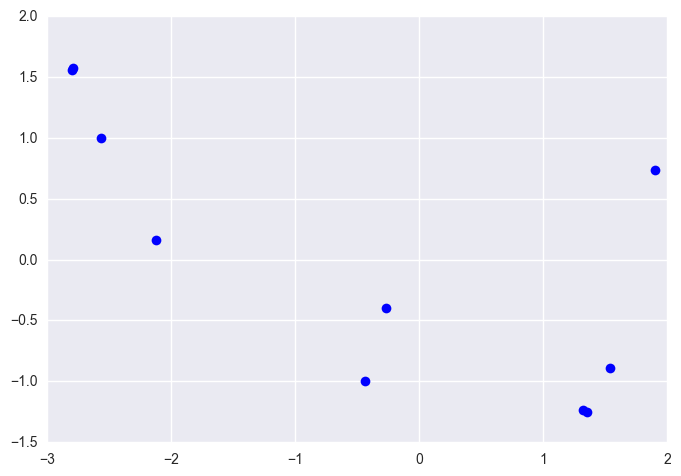

In [4]:
x = np.random.randn(10)*2
theta = [1, 10]
sigma = covariance(exponential_kernel, x, x, theta)
y = np.random.multivariate_normal(np.zeros(len(x)), sigma)
plt.plot(x, y, 'bo');

### Conditional distribution

We can generate sample functions (*realizations*) sequentially, using the conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

This function implements the conditional:

In [5]:
def conditional(x_new, x, y, fcov=exponential_kernel, params=theta):
    B = covariance(fcov, x_new, x, params)
    C = covariance(fcov, x, x, params)
    A = covariance(fcov, x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B).T.dot(y)
    sigma = A - np.linalg.inv(C).dot(B).T.dot(B)
    return(mu.squeeze(), sigma.squeeze())

The band plotted below represents the prior mean function, plus and minus one standard deviation.

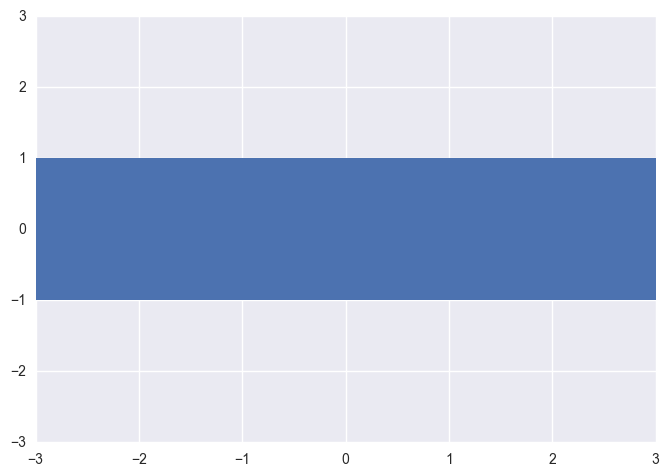

In [6]:
sigma0 = exponential_kernel(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma0, capsize=0)
plt.ylim(-3, 3);

We start by selecting a point at random, then drawing from an *unconditional* Gaussian:

In [7]:
x = [1.]
y = [np.random.normal(scale=sigma0)]
y

[-1.2793668900024635]

We can now calculate the conditional distribution, given the point that we just sampled.

In [8]:
sigma1 = covariance(exponential_kernel, x, x, theta)

In [9]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [10]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_kernel, theta, sigma1, y) 
               for i in x_pred]

Let's plot this to get an idea of what this looks like:

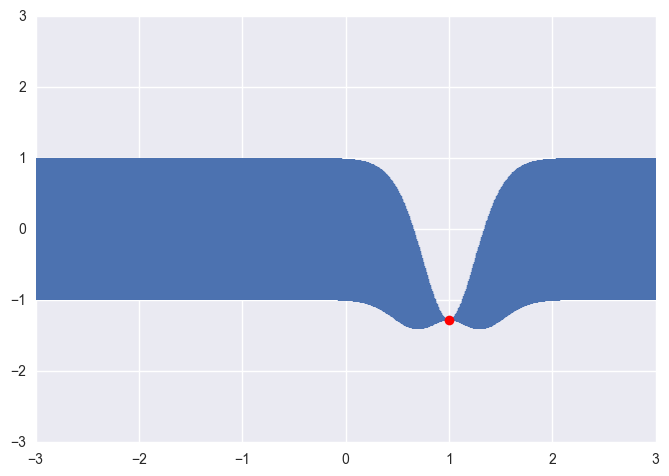

In [11]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Now, we can select a second point, conditional on the first point, using this new distribution. Let's arbitrarily select one at $x=-0.7$

In [12]:
mu2, s2 = conditional([-0.7], x, y)
y2 = np.random.normal(mu2, s2)
y2

-0.3822530996980265

In [13]:
x.append(-0.7)
y.append(y2)

We can calculate the conditional distribution again:

In [14]:
sigma2 = covariance(exponential_kernel, x, x, theta)

In [15]:
predictions = [predict(i, x, exponential_kernel, theta, sigma2, y) 
               for i in x_pred]

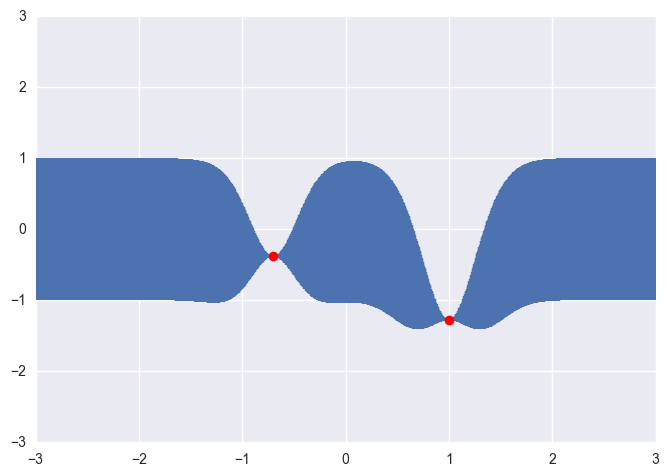

In [16]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Notice how the existing points constrain the selection of subsequent points.

In [17]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([ 0.24923286, -0.6789484 ,  0.0585416 ,  0.10131664,  0.59467425])

In [18]:
x += x_more
y += y_more.tolist()

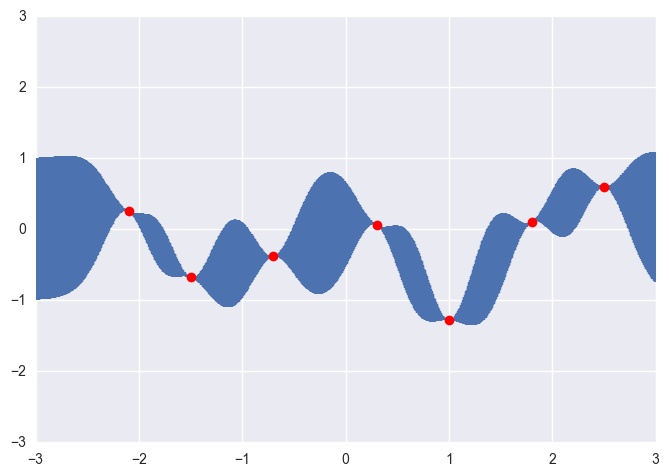

In [19]:
sigma_new = covariance(exponential_kernel, x, x, theta)

predictions = [predict(i, x, exponential_kernel, theta, sigma_new, y) 
               for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

Note that this is exactly equivalent to adding points simultaneously.

We are not restricted to a double-exponential covariance function. Here is a slightly more general function, which includes a constant and linear term, in addition to the exponential.

$$k(x,x\prime) = \theta_1 \exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right) + \theta_3 + \theta_4 x^{\prime} x$$

In [20]:
# Exponential kernel, plus constant and linear terms
def exponential_linear_kernel(x, y, params):
    return exponential_kernel(x, y, params[:2]) + params[2] + params[3] * np.dot(x, y)

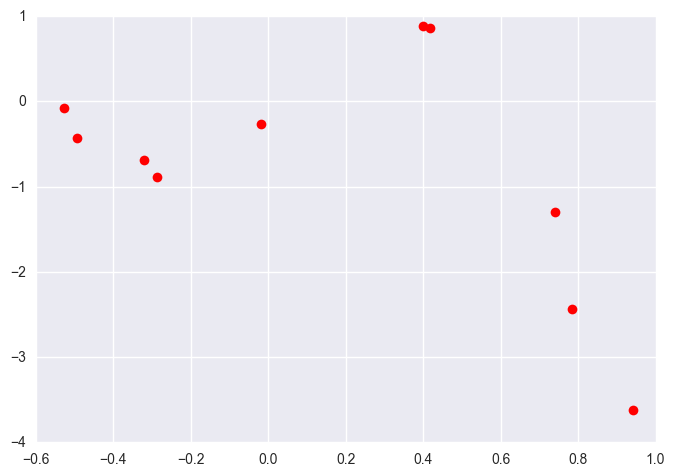

In [21]:
# Parameters for the expanded exponential kernel
theta = 2.0, 50.0, 0.0, 1.0

# Some sample training points.
xvals = np.random.rand(10) * 2 - 1

# Construct the Gram matrix
C = covariance(exponential_linear_kernel, xvals, xvals, theta)

# Sample from the multivariate normal
yvals = np.random.multivariate_normal(np.zeros(len(xvals)), C)

plt.plot(xvals, yvals, "ro");

In [22]:
x_pred = np.linspace(-1, 1, 1000)
predictions = [predict(i, xvals, exponential_linear_kernel, theta, C, yvals) 
               for i in x_pred]

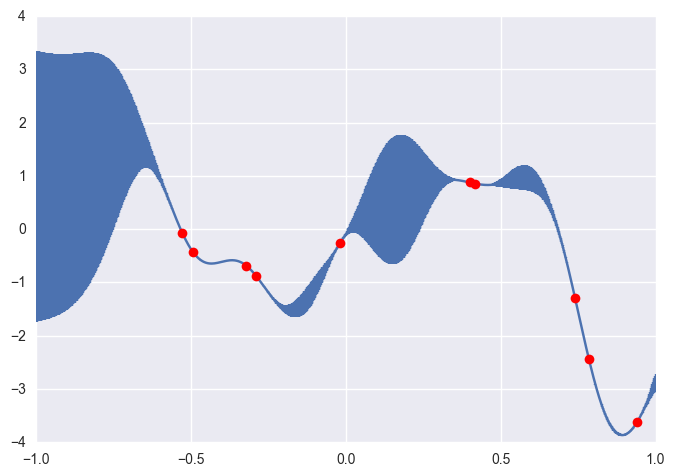

In [23]:
y, sigma = np.transpose(predictions)
plt.errorbar(x_pred, y, yerr=sigma, capsize=0)
plt.plot(xvals, yvals, "ro");

We can use the GP as a prior, and update it using data (rather than random realizations), to obtain a posterior GP that we can use for prediction, conditional on the data.

## Marginal Likelihood

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

GP prior:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

Gaussian likelihood:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

Marginal likelihood:

$$\log p(y|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginial likelihood.

These examples, of course, are trivial because they are simply random functions. What we are really interested in is *learning* about an underlying function from information residing in our data. In a parametric setting, we either specify a likelihood, which we then maximize with respect to the parameters, of a full probability model, for which we calculate the posterior in a Bayesian context. Though the integrals associated with posterior distributions are typically intractable for parametric models, they do not pose a problem with Gaussian processes.

## Gaussian process priors

We can treat our zero-mean (or otherwise arbitrary) Gaussian process as a prior for our model. If we are able to use a Gaussian as our data likelihood, then we can construct a Gaussian proceess posterior.

Keeping in mind that a Gaussian process is a distribution over functions, rather than parameters, our likelihood takes the following form:

$$y|p(x),x \sim \mathcal{N}(p(x), \sigma^2I) $$

Here, $\sigma^2$ represents observation error, or noise, and our unknown is a function.

Notice that the GP likelihood conditions on a function; however, we are only interested in the function at locations where we have data!

The corresponding prior is:

$$p(x) \sim \mathcal{GP}(m_0(x), k_0(x,x\prime))$$

Multiplying an infinite normal with another infinite normal yields another infinite normal, our posterior process:

$$p(x)|y \sim \mathcal{GP}(m_{post}, k_{post}(x,x^{\prime}))$$

where

$$\begin{aligned}
m_{post} &= k(x,x^{\prime})^T[k(x,x) + \sigma^2I]^{-1}y \\
k_{post}(x,x^{\prime}) &= k(x^{\prime},x^{\prime}) - k(x,x^{\prime})^T[k(x,x) + \sigma^2I]^{-1}k(x,x^{\prime})
\end{aligned}$$

The posterior predictive distribution for the GP is specified by:

$$\begin{aligned}
m^* &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*,x) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

Though this calculation may seem straightforward, but note that the mean and covariate calculations involve inversions $k(x,x)$, which is a $\mathcal{O}(n^3)$ computation. Thus, Gaussian processes as presented are usually only feasible for data up to a few thousand observations in size. If time allows, we'll tak about sparse approximations. 

## Gaussian Processes in GPy

Due to it's simplicity in syntax, we demonstrate several of the key components of GP regression using the package `GPy`. It is actively maintained by the Sheffield Computing Group. 

In [24]:
import GPy

For the purposes of demonstration, let's generate some toy data such that:
\begin{equation}
y_i = f(x_i)+\epsilon
\end{equation}

where 
$f(x) = 400 + 30\sin(.2X)$
and $\epsilon\sim \mathcal{N}(0,15)$

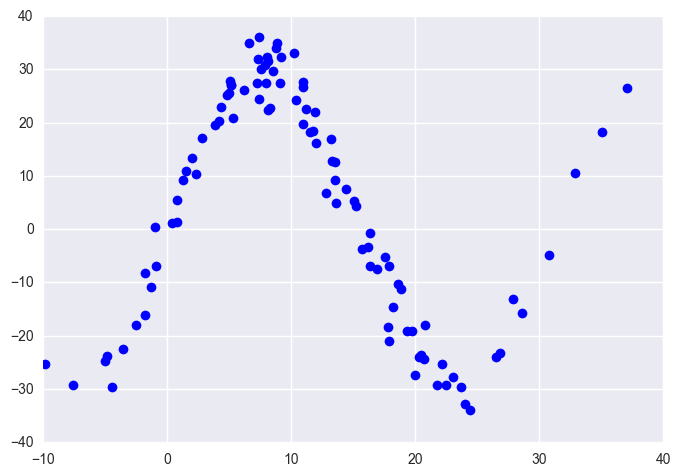

In [25]:
X = np.sort(10*np.random.randn(100)+10)
Y = 30*np.sin(.2*X)+np.random.multivariate_normal(np.repeat(0,100), 15*np.eye(100))
plt.plot(X, Y, "bo");

Our goal is to use the GP infrastructure to try and recover the true function $f$. 

### Mean function

The mean function of a GP can be interpreted as a "prior guess" at the form of the true function. Typically, we use a zero mean function (or some linear function), as we have seen above, but we can choose from a range of alternatives.

## Covariance function

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

The Mat&#232;rn class of functions is a flexible choice.

$$k_{Matern}(d) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} d}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} d}{l}\right)$$

The Mat&#232;rn covariance function has three parameters, each of which clearly controls one of three important properties of realizations.

**amplitude** ($\sigma$) (sometimes called "variance" and parameterized by $\sigma^2$)

The amplitude parameter (`amp` in PyMC) is a multiplier for realizations from the function that essentially stretches or compresses the y-axis.

**lengthscale of changes** ($l$)

The lengthscale parameter (`scale`) similarly scales realizations on the x-axis. Larger (greater than 1) values make points appear closer together.

**roughness** ($\nu$)

The roughness parameter (`diff_degree`) controls the sharpness of the ridge of the covariance function, which in turn affects the roughness (or smoothness) of realizations.

- The kernel function relates inputs to each other. Intuition: input points that are closer together might have similar output values (of course, this depends...)
- Pairwise evaluations of the kernel function produces a positive semidefinite Gram matrix.

In `GPy`, specification of the kernel is very easy:

In [26]:
kernel = GPy.kern.Matern32(1, variance=10, lengthscale=1.2)

Note, in GPy, the roughness is predetermined and comes in 2 separate Matern Functions

Calculation of the Gram matrix is very simple for our X:

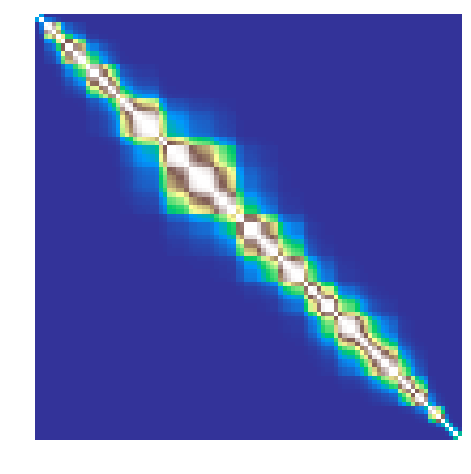

In [27]:
K_xx = kernel.K(X[:,None],X[:,None])
plt.imshow(np.asmatrix(K_xx), cmap='terrain', interpolation='nearest')
plt.axis('off');

### Exercise: hyperparameters

- Try playing around with the hyperparameters to see what we get. 
- Can you hypothesize how this will affect the draws of the function?

## Drawing realizations from a GP

Since a Gaussian process is a distribution over functions, sampling from it yields functions rather than points. In practice, however, we can only observe a finite number of points on the function. Since, by definition, a GP is an infinite collection of random variables, `any collection of which is multivariate Gaussian`, then a draw from the prior process is practically speaking a draw from a multivariate Gaussian with Covariance equal to the Gram Matrix above. 

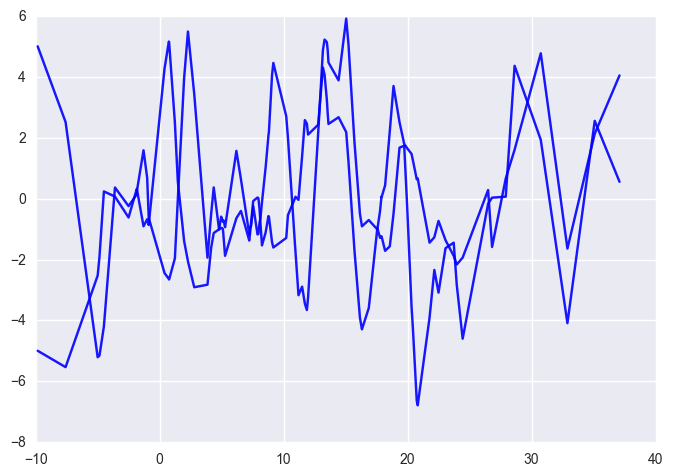

In [28]:
import scipy as sp
rv = sp.random.multivariate_normal(size = 2, mean = np.repeat(0,len(X)), cov = np.asmatrix(K_xx))
for draw in rv:
    plt.plot(X, draw, "b-", alpha=.9);

### Exercise: hyperparameters 

Try manipulating the hyperparameters. Does this match what you hypothesized?

Let's use a GP to model observations as coming from the toy function for which we are highly uncertain. We can model this data as:

$$ \text{data}_i \sim \text{N}(f(o_i), V_i) $$

which assumes only that the observation error is normally distributed. To represent the uncertainty regarding the expected value, we use a Gaussian process prior: 

$$ f \sim \text{GP}(M_o, C_o) $$ 

Combining these yields a posterior for *f* that is also a Gaussian process, with new mean and covariance functions:

$$ f|\text{data} \sim \text{GP}(M, C) $$

Recall that the posterior predictive distribution of a new testy point
is given by:
$$\begin{aligned}
m^* &= k(x,x^*)^T[k(x,x) + \sigma^2I]^{-1}y \\
k(x^*,x) &= k(x^*,x^*) +\sigma^2- k(x,x^*)^T[k(x,x) + \sigma^2I]^{-1}k(x, x^*)
\end{aligned}$$

### Exercise: 

Calculate the posterior predictive distribution for a set of test inputs. For now, assume the variance of the observations is known. 

In [29]:
grid = np.linspace(-20,40,100)[:,None]

In [30]:
# Write your answer here

So, we've conditioned on the data using only probabilistic arguments. Let's see how we did.

In [31]:
rv_posterior = sp.random.multivariate_normal(size = 200, mean = np.asarray(mean_f)[:,0], cov = cov_f)
plt.plot(X,Y,"bo")
for draw in rv_posterior:
    plt.plot(grid, draw, "r-", alpha=.1);


NameError: name 'mean_f' is not defined

As we can see, by just arbitrarily picking covariance function values gives a choppy fit. The typical route is to optimize the marginal likelihood. However, let's use GPy to do this...

Workflow in `GPy` is very straightforward. Steps are as follows:

    1. Define kernel function
    2. Define likelihood
    3. Optimize Hyperparameters (or use MCMC)
    4. Check out the results!
  

In [31]:
m = GPy.models.GPRegression(X=X[:,None], Y=Y[:,None],kernel=kernel)
m.optimize()

In [32]:
m

GP_regression.,value,constraints,priors
Mat32.variance,1110.33386701,+ve,
Mat32.lengthscale,17.5285903857,+ve,
Gaussian_noise.variance,13.3467169685,+ve,


Let's plug in these optimized values to the preceeding equations and see if we get a better fit.

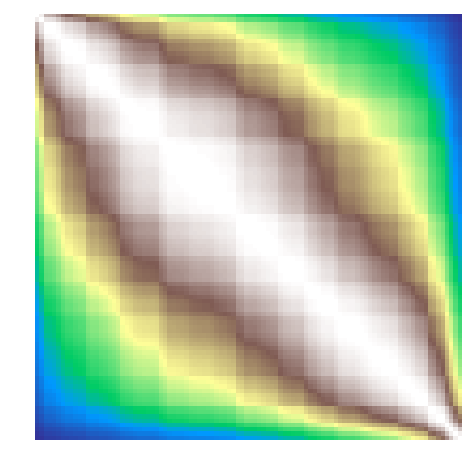

In [33]:
kernel = GPy.kern.Matern32(1, variance=908.3, lengthscale=14.62)
K_xx = kernel.K(X[:,None],X[:,None])
plt.imshow(np.asmatrix(K_xx), cmap='terrain', interpolation='nearest')
plt.axis('off');

In [34]:
s2 = 11
#K(x*,x*)
K_ss = np.asmatrix(kernel.K(grid,grid))
#K(x*,x)
K_xs = np.asmatrix(kernel.K(X[:, None],grid))

mean_f_fitted  = K_xs.T*np.linalg.inv(K_xx+s2*np.eye(100))*Y[:,None]
cov_f_fitted = K_ss + s2- K_xs.T*np.linalg.inv(K_xx+s2*np.eye(100))*K_xs+s2

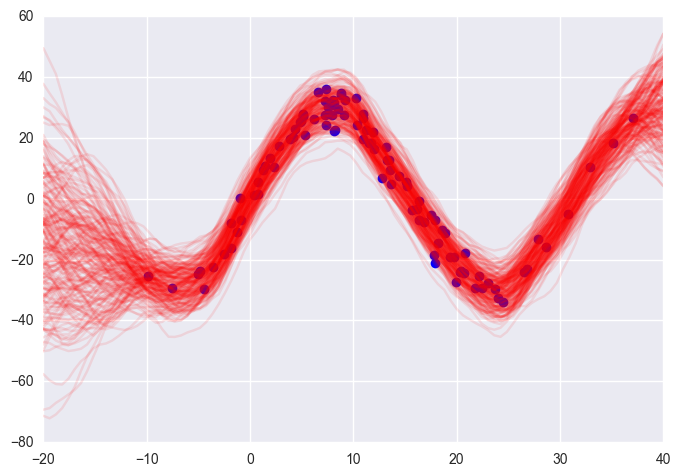

In [35]:
rv_posterior_fitted = sp.random.multivariate_normal(size = 200, 
                                                    mean = np.asarray(mean_f_fitted)[:,0], 
                                                    cov = cov_f_fitted)
plt.plot(X,Y,"bo")
for draw in rv_posterior_fitted:
    plt.plot(grid, draw, "r-", alpha=.1);

Of course, `GPy` has built in plotting:

 /Users/fonnescj/anaconda3/envs/bios8366/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


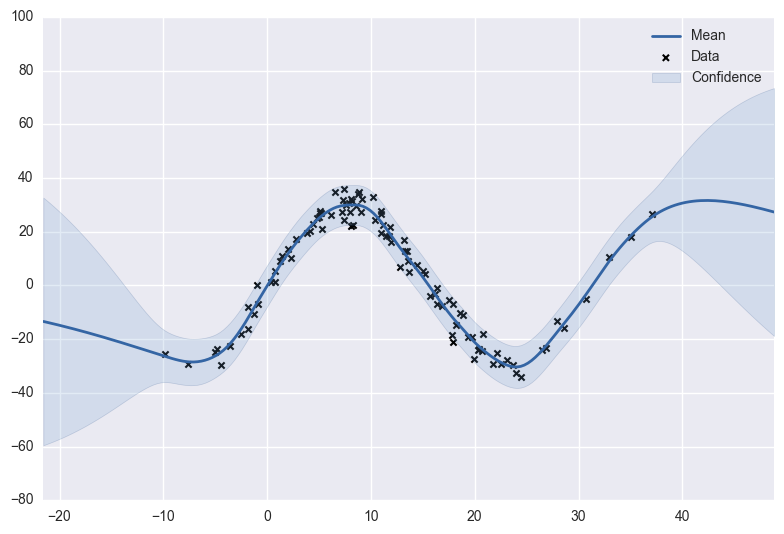

In [36]:
m.plot();

### Exercise: Covariance functions

Perform the regression using a different covariance function. The library of kernels for GPy are found in `GPy.kern`

In [37]:
# Write answer here

## Gaussian Processes in `PyMC`

GPs can be coded by hand in PyMC3:

In [38]:
from pymc3 import Model, MvNormal, HalfCauchy, sample, traceplot, summary, Metropolis, NUTS, Deterministic
import theano.tensor as T
from theano import shared
from theano.tensor.nlinalg import matrix_inverse

In [39]:
x = np.array([-5, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4, 
-3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3, -2.9, 
-2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.9, -1.8, 
-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, 
-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 
0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 
1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 
3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 
4.5, 4.6, 4.7, 4.8, 4.9, 5])

y = np.array([1.04442478194401, 0.948306088493654, 0.357037759697332, 0.492336514646604, 
0.520651364364746, 0.112629866592809, 0.470995468454158, -0.168442254267804, 
0.0720344402575861, -0.188108980535916, -0.0160163306512027, 
-0.0388792158617705, -0.0600673630622568, 0.113568725264636, 
0.447160403837629, 0.664421188556779, -0.139510743820276, 0.458823971660986, 
0.141214654640904, -0.286957663528091, -0.466537724021695, -0.308185884317105, 
-1.57664872694079, -1.44463024170082, -1.51206214603847, -1.49393593601901, 
-2.02292464164487, -1.57047488853653, -1.22973445533419, -1.51502367058357, 
-1.41493587255224, -1.10140254663611, -0.591866485375275, -1.08781838696462, 
-0.800375653733931, -1.00764767602679, -0.0471028950122742, -0.536820626879737, 
-0.151688056391446, -0.176771681318393, -0.240094952335518, -1.16827876746502, 
-0.493597351974992, -0.831683011472805, -0.152347043914137, 0.0190364158178343, 
-1.09355955218051, -0.328157917911376, -0.585575679802941, -0.472837120425201, 
-0.503633622750049, -0.0124446353828312, -0.465529814250314, 
-0.101621725887347, -0.26988462590405, 0.398726664193302, 0.113805181040188, 
0.331353802465398, 0.383592361618461, 0.431647298655434, 0.580036473774238, 
0.830404669466897, 1.17919105883462, 0.871037583886711, 1.12290553424174, 
0.752564860804382, 0.76897960270623, 1.14738839410786, 0.773151715269892, 
0.700611498974798, 0.0412951045437818, 0.303526087747629, -0.139399513324585, 
-0.862987735433697, -1.23399179134008, -1.58924289116396, -1.35105117911049, 
-0.990144529089174, -1.91175364127672, -1.31836236129543, -1.65955735224704, 
-1.83516148300526, -2.03817062501248, -1.66764011409214, -0.552154350554687, 
-0.547807883952654, -0.905389222477036, -0.737156477425302, -0.40211249920415, 
0.129669958952991, 0.271142753510592, 0.176311762529962, 0.283580281859344, 
0.635808289696458, 1.69976647982837, 1.10748978734239, 0.365412229181044, 
0.788821368082444, 0.879731888124867, 1.02180766619069, 0.551526067300283])

N = len(y)

We need to code our kernel, in this case, an exponential kernel.

In [40]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

We place Half Cauchy priors on the hyperparameters

In [50]:
with Model() as gp_fit:
    
    μ = np.zeros(N)
    
    η_sq = HalfCauchy('η_sq', 5)
    ρ_sq = HalfCauchy('ρ_sq', 5)
    σ_sq = HalfCauchy('σ_sq', 5)
    
    D = squared_distance(x, x)
    
    # Squared exponential
    Σ = T.fill_diagonal(η_sq * T.exp(-ρ_sq * D), η_sq + σ_sq)
    
    obs = MvNormal('obs', μ, cov=Σ, observed=y)

Applied log-transform to η_sq and added transformed η_sq_log_ to model.
Applied log-transform to ρ_sq and added transformed ρ_sq_log_ to model.
Applied log-transform to σ_sq and added transformed σ_sq_log_ to model.


In [51]:
with gp_fit:
    
    # Prediction over grid
    xgrid = np.linspace(-6, 6)
    D_pred = squared_distance(xgrid, xgrid)
    D_off_diag = squared_distance(x, xgrid)
    
    # Covariance matrices for prediction
    Σ_pred = η_sq * T.exp(-ρ_sq * D_pred)
    Σ_off_diag = η_sq * T.exp(-ρ_sq * D_off_diag)
    
    # Posterior mean
    μ_post = Deterministic('μ_post', T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), y))
    # Posterior covariance
    Σ_post = Deterministic('Σ_post', Σ_pred - T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T))

In [52]:
with gp_fit:
    gp_trace = sample(1000)

Assigned NUTS to η_sq_log_
Assigned NUTS to ρ_sq_log_
Assigned NUTS to σ_sq_log_
100%|██████████| 1000/1000 [00:31<00:00, 31.99it/s]


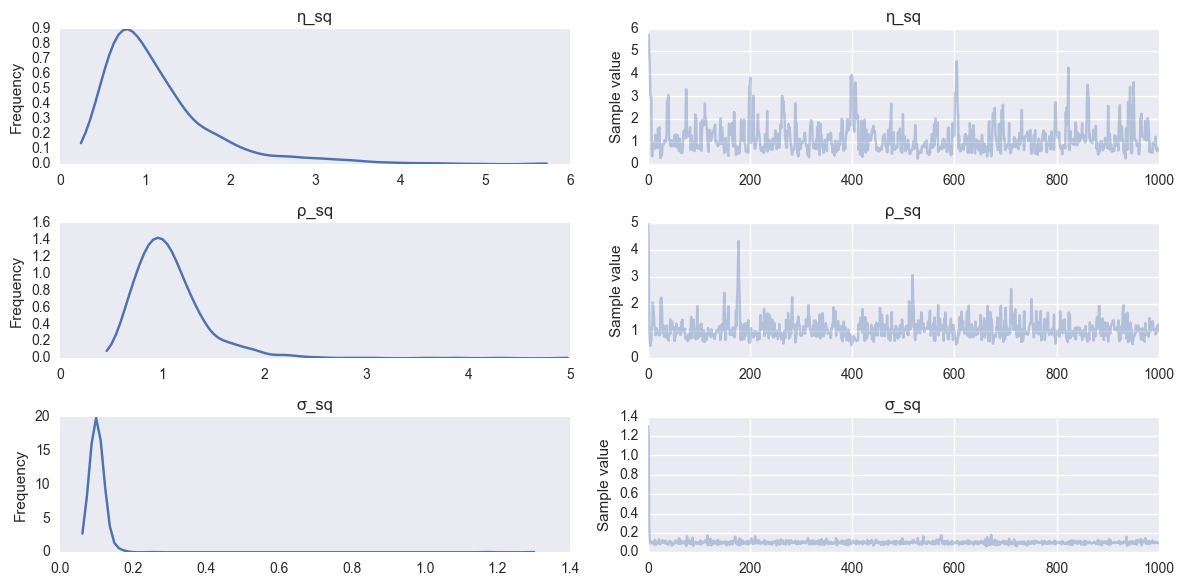

In [53]:
traceplot(gp_trace, varnames=['η_sq', 'ρ_sq', 'σ_sq']);

In [54]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(gp_trace['μ_post'][-100:], gp_trace['Σ_post'][-100:])]

 /Users/fonnescj/anaconda3/envs/bios8366/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning:covariance is not positive-semidefinite.


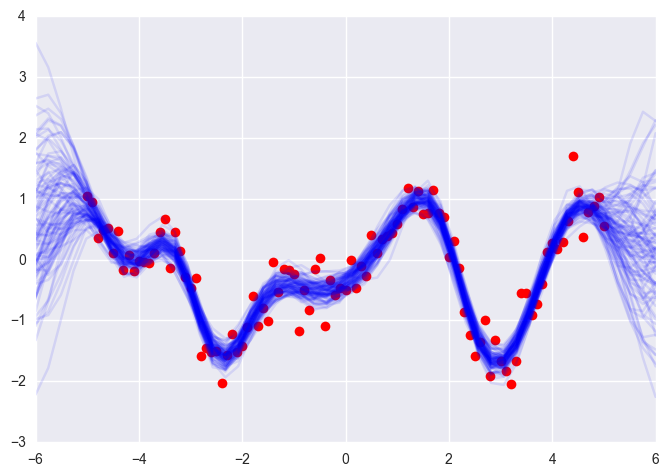

In [55]:
plt.plot(x, y, 'ro')

for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, 'b-', alpha=0.1);

## Example: Nashville daily temperatures

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Use a Gaussian process to fit a regression model to this data.

In [56]:
import pandas as pd

daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

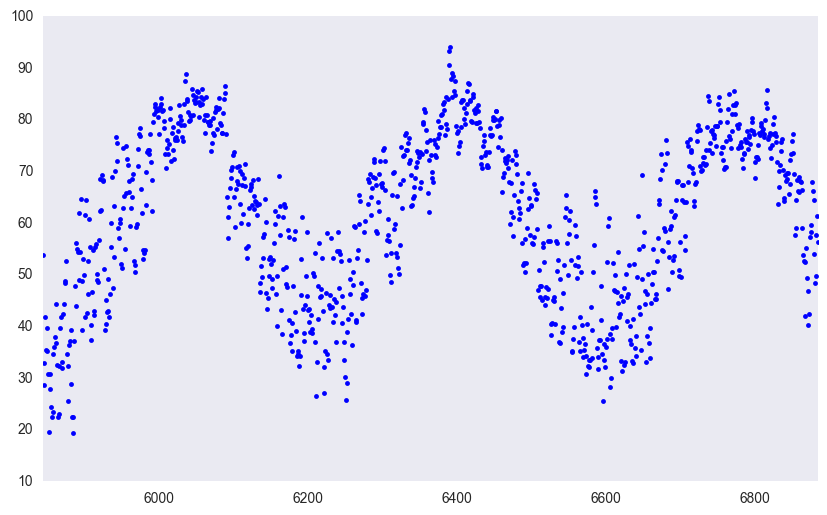

In [57]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

In [ ]:
# Write your answer here 

## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)